This file contains python code to mimic real setting

It is under the logi setting

Now, I use the same beta from the paper but the PSD as X

In [19]:
import sys
sys.path.append("../../mypkg")

In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from pprint import pprint
import itertools
from scipy.stats import chi2


In [21]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT
from hdf_utils.data_gen import gen_simu_psd_dataset
from hdf_utils.SIS import SIS_GLIM
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse, cholesky_inv
from utils.functions import logit_fn
from utils.misc import save_pkl, load_pkl
from splines import obt_bsp_obasis_Rfn, obt_bsp_basis_Rfn_wrapper
from projection import euclidean_proj_l1ball
from optimization.opt import HDFOpt
from scenarios.real_simu_logi import settings

from joblib import Parallel, delayed

In [23]:
plt.style.use(FIG_ROOT/"base.mplstyle")
torch.set_default_tensor_type(torch.DoubleTensor)

# Params

In [24]:
np.random.seed(0)
c = 0

setting = settings.n1
data_gen_params = setting.data_gen_params
data_gen_params.cs = data_gen_params.cs_fn(c)
data_gen_params.gt_beta = data_gen_params.beta_fn(data_gen_params.cs)

num_rep = 200
Cmat = np.eye(data_gen_params.d - len(setting.sel_idx))
save_dir = RES_ROOT/f"simu_logi_setting{setting.setting}_test"
if not save_dir.exists():
    save_dir.mkdir()

In [25]:
def _get_logi_int(data_gen_params, n_jobs=30, num_rep=100):
    ress = []
    for inte in tqdm(data_gen_params.intercept_cans):
        gt_alp = np.concatenate([[inte], data_gen_params.gt_alp0])
        def _run_fn(seed, data_gen_params=data_gen_params):
            data = gen_simu_psd_dataset(n=data_gen_params.n, 
                                        d=data_gen_params.d, 
                                        q=data_gen_params.q, 
                                        types_=data_gen_params.types_, 
                                        gt_alp=gt_alp, 
                                        gt_beta=data_gen_params.gt_beta, 
                                        freqs=data_gen_params.freqs, 
                                        data_type=data_gen_params.data_type, 
                                        data_params=data_gen_params.data_params, 
                                        seed=seed, 
                                        is_std=data_gen_params.is_std, 
                                        verbose=1, 
                                        is_gen=False);
            return data.Y.numpy()
        with Parallel(n_jobs=n_jobs) as parallel:
            res = parallel(delayed(_run_fn)(seed) for seed in range(num_rep))
        ress.append(np.array(res))


    # get the intercept
    Yms = np.array([res.mean() for res in ress])
    intercept = data_gen_params.intercept_cans[np.argmin(np.abs(Yms-0.5))]
    print(f"The mean of Y is {Yms[np.argmin(np.abs(Yms-0.5))]:.3f} under intercept {intercept:.3f}.")
    gt_alp = np.concatenate([[intercept], data_gen_params.gt_alp0])
    return gt_alp

In [26]:
data_gen_params.gt_alp = _get_logi_int(data_gen_params, 5);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it]

The mean of Y is 0.435 under intercept -7.158.


# Simu

## Check data gen fn

In [27]:
data = gen_simu_psd_dataset(n=data_gen_params.n, 
                            d=data_gen_params.d, 
                            q=data_gen_params.q, 
                            types_=data_gen_params.types_, 
                            gt_alp=data_gen_params.gt_alp, 
                            gt_beta=data_gen_params.gt_beta, 
                            freqs=data_gen_params.freqs, 
                            data_type=data_gen_params.data_type, 
                            data_params=data_gen_params.data_params, 
                            seed=0, 
                            is_std=data_gen_params.is_std, 
                            verbose=1, 
                            is_gen=False);

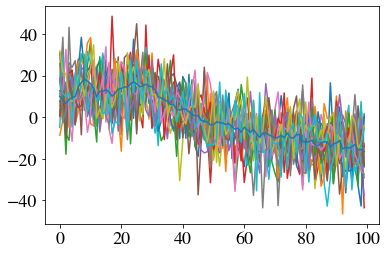

In [28]:
sub_idx = 100
for roi_ix in range(20):
    plt.plot(data.X[sub_idx, roi_ix, :])
plt.plot(data.X[sub_idx, :, :].mean(axis=0))

## SIS check (just for check)

In [29]:
def _SIS_fn(seed, SIS_ratio, N, SIS_pen, setting):
    torch.set_default_dtype(torch.double)
    np.random.seed(seed)
    torch.manual_seed(seed)
        
    data_gen_params = edict(setting.data_gen_params.copy())
    basis_mat = torch.tensor(obt_bsp(np.linspace(0, 1, data_gen_params.npts), N, 4)).to(torch.get_default_dtype())
    #basis_mat = torch.tensor(obt_bsp(np.linspace(2, 45, data_gen_params.npts), N, 4)).to(torch.get_default_dtype())
    cur_data = gen_simu_psd_dataset(n=data_gen_params.n, 
                                    d=data_gen_params.d, 
                                    q=data_gen_params.q, 
                                    types_=data_gen_params.types_, 
                                    gt_alp=data_gen_params.gt_alp, 
                                    gt_beta=data_gen_params.gt_beta, 
                                    freqs=data_gen_params.freqs, 
                                    data_type=data_gen_params.data_type, 
                                    data_params=data_gen_params.data_params, 
                                    seed=seed, 
                                    is_std=data_gen_params.is_std, 
                                    verbose=1, 
                                    is_gen=False);
    
    keep_idxs, _  = SIS_GLIM(Y=cur_data.Y, X=cur_data.X, Z=cur_data.Z, 
                             basis_mat=basis_mat, keep_ratio=SIS_ratio, 
                             model_type=setting.model_type, SIS_pen=SIS_pen, sel_idx=setting.sel_idx)
    M_idxs = np.delete(np.arange(data_gen_params.d), setting.sel_idx)
    keep_idxs = np.sort(np.concatenate([M_idxs, keep_idxs]))
    return keep_idxs

In [30]:
obt_bsp = obt_bsp_obasis_Rfn
num_rep = 200
with Parallel(n_jobs=5) as parallel:
    keep_idxss = parallel(delayed(_SIS_fn)(seed, 0.20, N=8, SIS_pen=0.02, setting=setting) for seed in 
                          tqdm(range(0, num_rep), total=num_rep))

  0%|                                                                                                                                                  | 0/200 [00:00<?, ?it/s]R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


100%|██████████████████████████████

Text(0.5, 1.0, '[0.2   0.18  0.18  0.185 0.19  0.175 1.   ]')

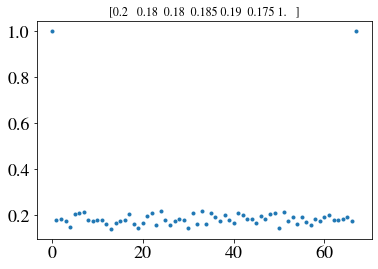

In [31]:
vs, cts = np.unique(np.concatenate(keep_idxss), return_counts=1);
cts = cts[np.argsort(vs)]/len(keep_idxss)
vs = np.sort(vs);
plt.plot(vs, cts, ".")
plt.title(f"{cts[vs > 60]}")

## Simulation

In [10]:
def _run_fn(seed, lam, N, setting, is_save=False, is_cv=False, verbose=2):
    """Now (on Aug 25, 2023), if we keep seed the same, the cur_data is the same. 
       If you want to make any changes, make sure this. 
    """
    torch.set_default_dtype(torch.double)
    np.random.seed(seed)
    torch.manual_seed(seed)
        
    _setting = edict(setting.copy())
    _setting.seed = seed
    _setting.lam = lam
    _setting.N = N
    
    data_gen_params = setting.data_gen_params
    
    f_name = f"seed_{seed:.0f}-lam_{lam*1000:.0f}-N_{N:.0f}_fit.pkl"
    
    
    if not (save_dir/f_name).exists():
        cur_data = gen_simu_psd_dataset(n=data_gen_params.n, 
                            d=data_gen_params.d, 
                            q=data_gen_params.q, 
                            types_=data_gen_params.types_, 
                            gt_alp=data_gen_params.gt_alp, 
                            gt_beta=data_gen_params.gt_beta, 
                            freqs=data_gen_params.freqs, 
                            data_type=data_gen_params.data_type, 
                            data_params=data_gen_params.data_params, 
                            seed=seed, 
                            is_std=data_gen_params.is_std, 
                            verbose=verbose, 
                            is_gen=False);
        hdf_fit = HDFOpt(lam=_setting.lam, 
                         sel_idx=_setting.sel_idx, 
                         model_type=_setting.model_type,
                         verbose=verbose, 
                         SIS_ratio=_setting.SIS_ratio, 
                         N=_setting.N,
                         is_std_data=True, 
                         cov_types=None, 
                         inits=None,
                         model_params = _setting.model_params, 
                         SIS_params = _setting.SIS_params, 
                         opt_params = _setting.opt_params,
                         bsp_params = _setting.bsp_params, 
                         pen_params = _setting.pen_params
               );
        hdf_fit.add_data(cur_data.X, cur_data.Y, cur_data.Z)
        opt_res = hdf_fit.fit()
        
        if is_cv:
            hdf_fit.get_cv_est(_setting.num_cv_fold)
        if is_save:
            hdf_fit.save(save_dir/f_name, is_compact=False, is_force=True)
    else:
        hdf_fit = load_pkl(save_dir/f_name, verbose>=2);
        
    return hdf_fit


### single test

In [17]:
seed = 2
lam = 0.2
N = 6 

setting.SIS_ratio = 0.2
res = _run_fn(seed=seed, lam=lam, N=N, setting=setting, is_cv=False, is_save=False, verbose=2)
res.hypo_test(Cmat)

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_real/../../mypkg/../mid_results/PSD_d-68_n-500_npts-100_is_std-False/seed_2.pkl


2024-01-15 16:35:16,167 - optimization.opt - INFO - opt parmas is {'stop_cv': 0.0005, 'max_iter': 2000, 'one_step_verbose': 0, 'alpha': 0.9, 'beta': 1.5, 'R': 200000.0, 'N_eps': 0.0001, 'N_maxit': 100, 'is_BFGS': 'adaptive'}.
2024-01-15 16:35:16,168 - optimization.opt - INFO - SIS parmas is {'SIS_pen': 0.02, 'SIS_basis_N': 8, 'SIS_basis_ord': 4, 'SIS_ratio': 0.2}.
2024-01-15 16:35:16,168 - optimization.opt - INFO - model parmas is {}.
2024-01-15 16:35:16,169 - optimization.opt - INFO - penalty parmas is {'a': 3.7, 'lam': 0.2}.
2024-01-15 16:35:16,169 - optimization.opt - INFO - bspline parmas is {'basis_ord': 4, 'is_orth_basis': True, 'N': 6}.
2024-01-15 16:35:16,169 - optimization.opt - INFO - As cov_types is not provided, inferring the continuous covariates.
Main Loop:   2%|█▊                                                                                        | 40/2000 [00:00<00:47, 41.20it/s, error=0.00185, GamL0=2, CV=0.0005]
2024-01-15 16:35:17,584 - optimization.opt - INFO - h

{'pval': 0.3193537012746873, 'T_v': tensor(7.0162)}

In [18]:
seed = 2
lam = 0.2
N = 6 

setting.SIS_ratio = 1
res = _run_fn(seed=seed, lam=lam, N=N, setting=setting, is_cv=False, is_save=False, verbose=2)
res.hypo_test(Cmat)

2024-01-15 16:35:24,922 - optimization.opt - INFO - opt parmas is {'stop_cv': 0.0005, 'max_iter': 2000, 'one_step_verbose': 0, 'alpha': 0.9, 'beta': 1.5, 'R': 200000.0, 'N_eps': 0.0001, 'N_maxit': 100, 'is_BFGS': 'adaptive'}.
2024-01-15 16:35:24,922 - optimization.opt - INFO - SIS parmas is {'SIS_pen': 0.02, 'SIS_basis_N': 8, 'SIS_basis_ord': 4, 'SIS_ratio': 1}.
2024-01-15 16:35:24,923 - optimization.opt - INFO - model parmas is {}.
2024-01-15 16:35:24,923 - optimization.opt - INFO - penalty parmas is {'a': 3.7, 'lam': 0.2}.
2024-01-15 16:35:24,924 - optimization.opt - INFO - bspline parmas is {'basis_ord': 4, 'is_orth_basis': True, 'N': 6}.
2024-01-15 16:35:24,924 - optimization.opt - INFO - As cov_types is not provided, inferring the continuous covariates.


Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_real/../../mypkg/../mid_results/PSD_d-68_n-500_npts-100_is_std-False/seed_2.pkl


Main Loop:   2%|██▏                                                                                        | 48/2000 [00:30<20:55,  1.55it/s, error=0.0157, GamL0=3, CV=0.0005]
2024-01-15 16:35:55,823 - optimization.opt - INFO - hypo parmas is {'svdinv_eps_Q': 1e-07, 'svdinv_eps_Psi': 1e-07, 'Cmat': array([[1.]])}.


{'pval': 0.2772457878129873, 'T_v': tensor(7.4979)}

In [20]:
from utils.misc import bcross_entropy_loss
def _get_valset_metric_fn(res):
    valsel_metrics = edict()
    valsel_metrics.entroy_loss = bcross_entropy_loss(res.cv_Y_est, res.Y.numpy());
    valsel_metrics.mse_loss = np.mean((res.cv_Y_est- res.Y.numpy())**2);
    valsel_metrics.mae_loss = np.mean(np.abs(res.cv_Y_est-res.Y.numpy()));
    valsel_metrics.cv_probs = res.cv_Y_est
    valsel_metrics.tY = res.Y.numpy()
    return valsel_metrics
def _run_fn_extract(seed, N, lam, c1):
    f_name = f"seed_{seed:.0f}-lam_{lam*1000:.0f}-N_{N:.0f}-c1_{c1*1000:.0f}_fit.pkl"
    res = load_pkl(save_dir/f_name, verbose=0)
    return (seed, N, lam), _get_valset_metric_fn(res)

In [ ]:
est_beta = res.basis_mat @ res.est_Gam
gt_beta = paras.beta_GT[:, res.keep_idxs]
idx = -1
plt.plot(est_beta[:, idx], label="EST")
plt.plot(gt_beta[:, idx], label="GT")
plt.legend()

### Multipe test

In [18]:
def outlier_det(T_vs, ratio_tol=0.05):
    """
    Detects outliers in a given dataset using the interquartile range (IQR) method.

    Parameters:
    - T_vs (array-like): The input dataset.
    - ratio_tol (float, optional): The tolerance ratio for outlier removal. Default is 0.05.

    Returns:
    - kpidx (ndarray): A boolean array indicating whether each data point is an outlier or not.
    """
    Q1, Q3 = np.quantile(T_vs, [0.25, 0.75])
    IQR = Q3 - Q1
    upbd = Q3 + 1.5*IQR
    lowbd = Q1 - 1.5*IQR
    kpidx = np.bitwise_and(T_vs>=lowbd, T_vs<=upbd)
    
    if np.mean(kpidx)+ ratio_tol < 1:
        out_part = np.stack([T_vs - upbd, lowbd - T_vs]).T.max(axis=1);
        kpidx = np.ones(len(T_vs), dtype=bool)
        kpidx[np.argsort(-out_part)[:int(len(T_vs)*ratio_tol)]] = False
    return kpidx

In [24]:
seed = 12
N = 6
lam = 0.20
setting.opt_params.beta = 1.5
def _run_fn1(seed):
    res = _run_fn(seed=seed, lam=lam, N=N, setting=setting, is_cv=False, verbose=1)
    res.hypo_test(setting.Cmat, is_simpler=False)
    test_res = edict()
    test_res.update(res.hypo_test_res)
    test_res.L0 = torch.sum(torch.linalg.norm(res.est_Gam, axis=0)!=0).item()
    test_res.iters = res.conv_iter
    return test_res
    
num_rep = 200
with Parallel(n_jobs=20) as parallel:
    test_ress = parallel(delayed(_run_fn1)(seed) for seed in tqdm(range(num_rep), total=num_rep))
    




  0%|                                                                                                                                                  | 0/200 [00:00<?, ?it/s]


 10%|█████████████▋                                                                                                                           | 20/200 [00:00<00:02, 77.22it/s]2024-01-03 16:40:21,776 - optimization.opt - INFO - opt parmas is {'svdinv_eps_Q': 1e-07, 'svdinv_eps_Psi': 1e-07, 'Cmat': array([[1.]])}.



 20%|███████████████████████████▍                                                                                                             | 40/200 [00:02<00:13, 12.16it/s]R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to 

The size is 0.052 and the mean of Tv is 6.520 and thoeretically it is 6. L0 is 2.93.


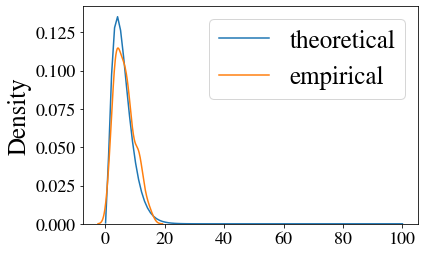

In [26]:
pvals = np.array([res.pval for res in test_ress])
T_vs = np.array([res.T_v for res in test_ress]);
L0s = np.array([res.L0 for res in test_ress]);
chi_df = setting.Cmat.shape[0]*N
kpidx = outlier_det(T_vs, 0.05)
print(
    f"The size is {np.mean(pvals[kpidx]<0.05):.3f} and "
    f"the mean of Tv is {np.mean(T_vs[kpidx]):.3f} and thoeretically it is {chi_df:.0f}. "
    f"L0 is {np.mean(L0s[kpidx]):.2f}."
     )

chi_df = setting.Cmat.shape[0]*N
xs = np.linspace(0.1, 100, 100)
theo_curvs_log = chi2.logpdf(xs, chi_df);
plt.plot(xs, np.exp(theo_curvs_log) , label="theoretical")
sns.kdeplot(T_vs[kpidx], label="empirical")
plt.legend()